<img style="float:left" width="70%" src="../../documentacion/imagenes/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="10%" src="../../documentacion/imagenes/PythonLogo.svg">
<br style="clear:both;">


<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">8.3. Deep Learning LSTM</h2>


 
## Estudiante:

- Jose Luis Perez Gomez

In [15]:
%run 3.Importaciones.ipynb
%run 4.Variables_Clases.ipynb

In [16]:
datosEEG_seg1_standarizado = pd.read_csv('../datos/csv/seg1_stscaler.csv', sep=',')
datosEEG_seg2_standarizado = pd.read_csv('../datos/csv/seg2_stscaler.csv', sep=',')
datosEEG_seg3_standarizado = pd.read_csv('../datos/csv/seg3_stscaler.csv', sep=',')
datosEEG_seg4_standarizado = pd.read_csv('../datos/csv/seg4_stscaler.csv', sep=',')
datosEEG_std_after = pd.read_csv('../datos/csv/all_stscaler_after.csv', sep=',')
datosEEG_std_before = pd.read_csv('../datos/csv/all_stscaler_before.csv', sep=',')


datosEEG_all = [datosEEG_seg1_standarizado, datosEEG_seg2_standarizado, datosEEG_seg3_standarizado, datosEEG_seg4_standarizado, datosEEG_std_after, datosEEG_std_before]
datosEEG_all_nombres = {'segmento_1':datosEEG_seg1_standarizado, 'segmento_2':datosEEG_seg2_standarizado, 'segmento_3':datosEEG_seg3_standarizado,'segmento_4':datosEEG_seg4_standarizado, 'all_std_after':datosEEG_std_after, 'all_std_before':datosEEG_std_before}
nombre_clases = valores_key(datosEEG_seg1_standarizado)


# LSTM (Long short-term memory)

In [17]:
X_train, y_train, X_val, y_val, X_test, y_test = dividir_datos(datosEEG_std_after)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))




In [18]:
# Definir parámetros
timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = len(np.unique(y_train))

model_lstm = Sequential([
    LSTM(units=30, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.3),
    LSTM(units=30),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Learning rate personalizado
learning_rate = 0.0005  # Puedes ajustar este valor

# Definir el optimizador con el learning rate personalizado
optimizer = Adam(learning_rate=learning_rate)


model_lstm.compile(optimizer= optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy')

C:\Users\Casa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


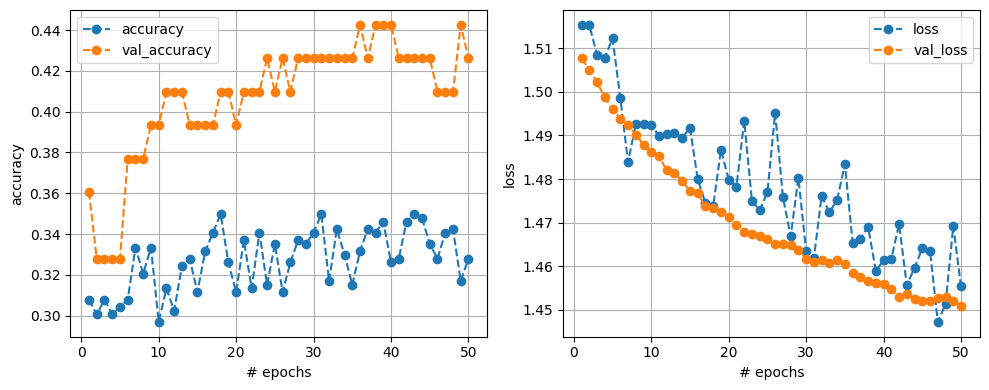

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3343 - loss: 1.4370 - val_accuracy: 0.4262 - val_loss: 1.4509
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [19]:

accuracy_score_lstm = []
accuracy_score_test_lstm =[]
matriz_confusion_lstm = []
matriz_confusion_test_lstm = []
total_simple_lstm_trained = []

for dataset in datosEEG_all:
    
    X_train, y_train, X_val, y_val, X_test, y_test = dividir_datos(dataset)
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        
    # Entrenar el modelo
    #model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=50, batch_size=30, validation_data= (X_val, y_val), callbacks=[early_stopping, plot_learning, timer_callback, reduce_rl, model_checkpoint])
    model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=50, batch_size=30, validation_data= (X_val, y_val), callbacks=[plot_learning])
    
    y_pred = model_lstm.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy_score_lstm.append(accuracy_score(y_test, y_pred_classes))
    matriz_confusion_lstm.append(confusion_matrix(y_test, y_pred_classes))
    
    #simple_rnn_loss, simple_rnn_accuracy = model_srnn.evaluate(X_test, y_test)
    total_simple_lstm_trained.append(model_lstm_trained)



,LSTM
Segmento 1,0.461538
Segmento 2,0.312500
Segmento 3,0.350000
Segmento 4,0.300000
All Segmentos after,0.294118
All Segmentos before,0.338235


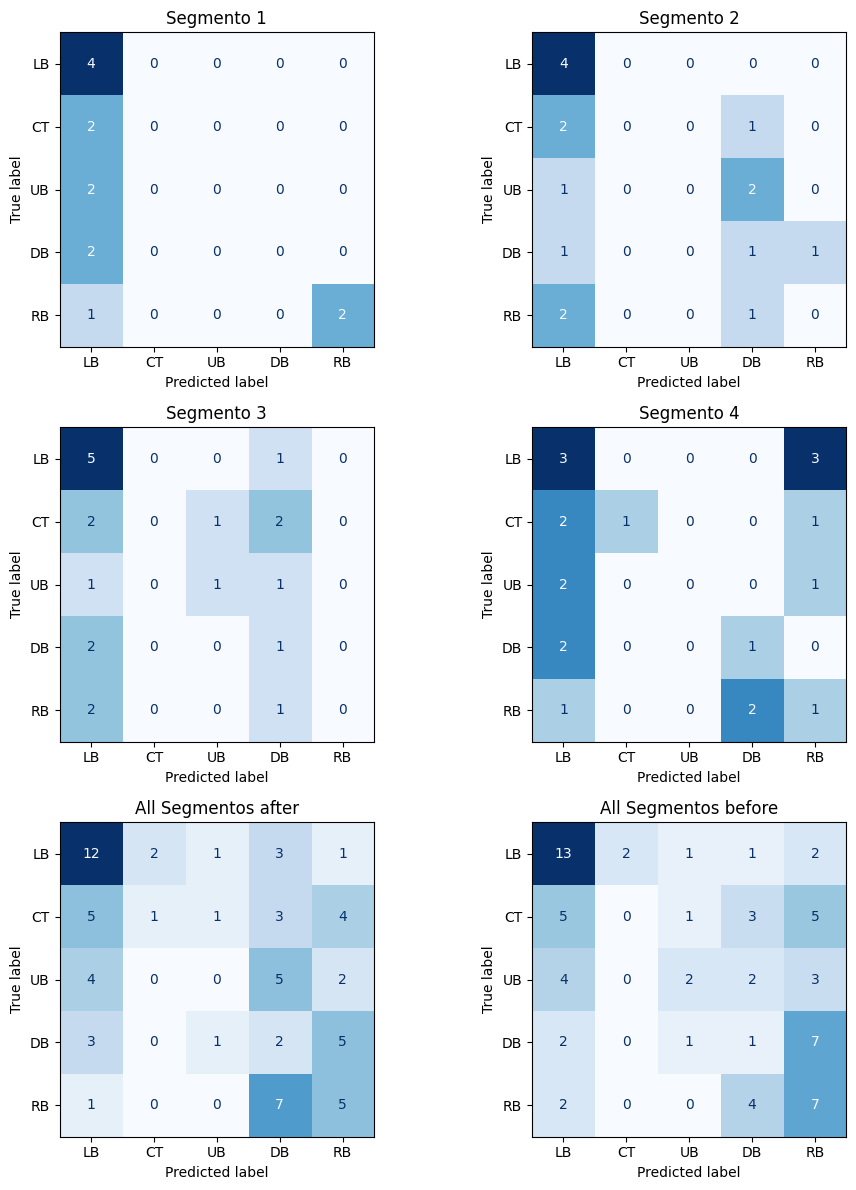

In [20]:
datos_lstm = pd.DataFrame(accuracy_score_lstm, columns=['LSTM'], index=(titulos_all))

display(datos_lstm)

mc_lstm = []

for matrices_lstm in matriz_confusion_lstm:

    mc_lstm.append(pd.DataFrame(matrices_lstm, index=nombre_clases, columns=nombre_clases))

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# Creo una figura y ejes para dividir el espacio en cuatro subgráficos
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

# Matrices de confusión y títulos para cada subgráfico
dataframes = [mc_lstm[0], mc_lstm[1], mc_lstm[2], mc_lstm[3], mc_lstm[4], mc_lstm[5]]


# Itero sobre los DataFrames y títulos para imprimir matriz de confusión en un subgráfico
for i, (dataframe, titulo) in enumerate(zip(dataframes, titulos_all)):
    fila = i // 2
    columna = i % 2
    ax = axs[fila, columna]
   
    # Se crea la impresion de la matriz de confusión y se implime
    disp = ConfusionMatrixDisplay(confusion_matrix=dataframe.values, display_labels=(nombre_clases))
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    
    # Añado el título al subgráfico
    ax.set_title(titulo)

# Se ajusta el espaciado entre subgráficos
plt.tight_layout()

# Se imprime el gráfico
plt.show()

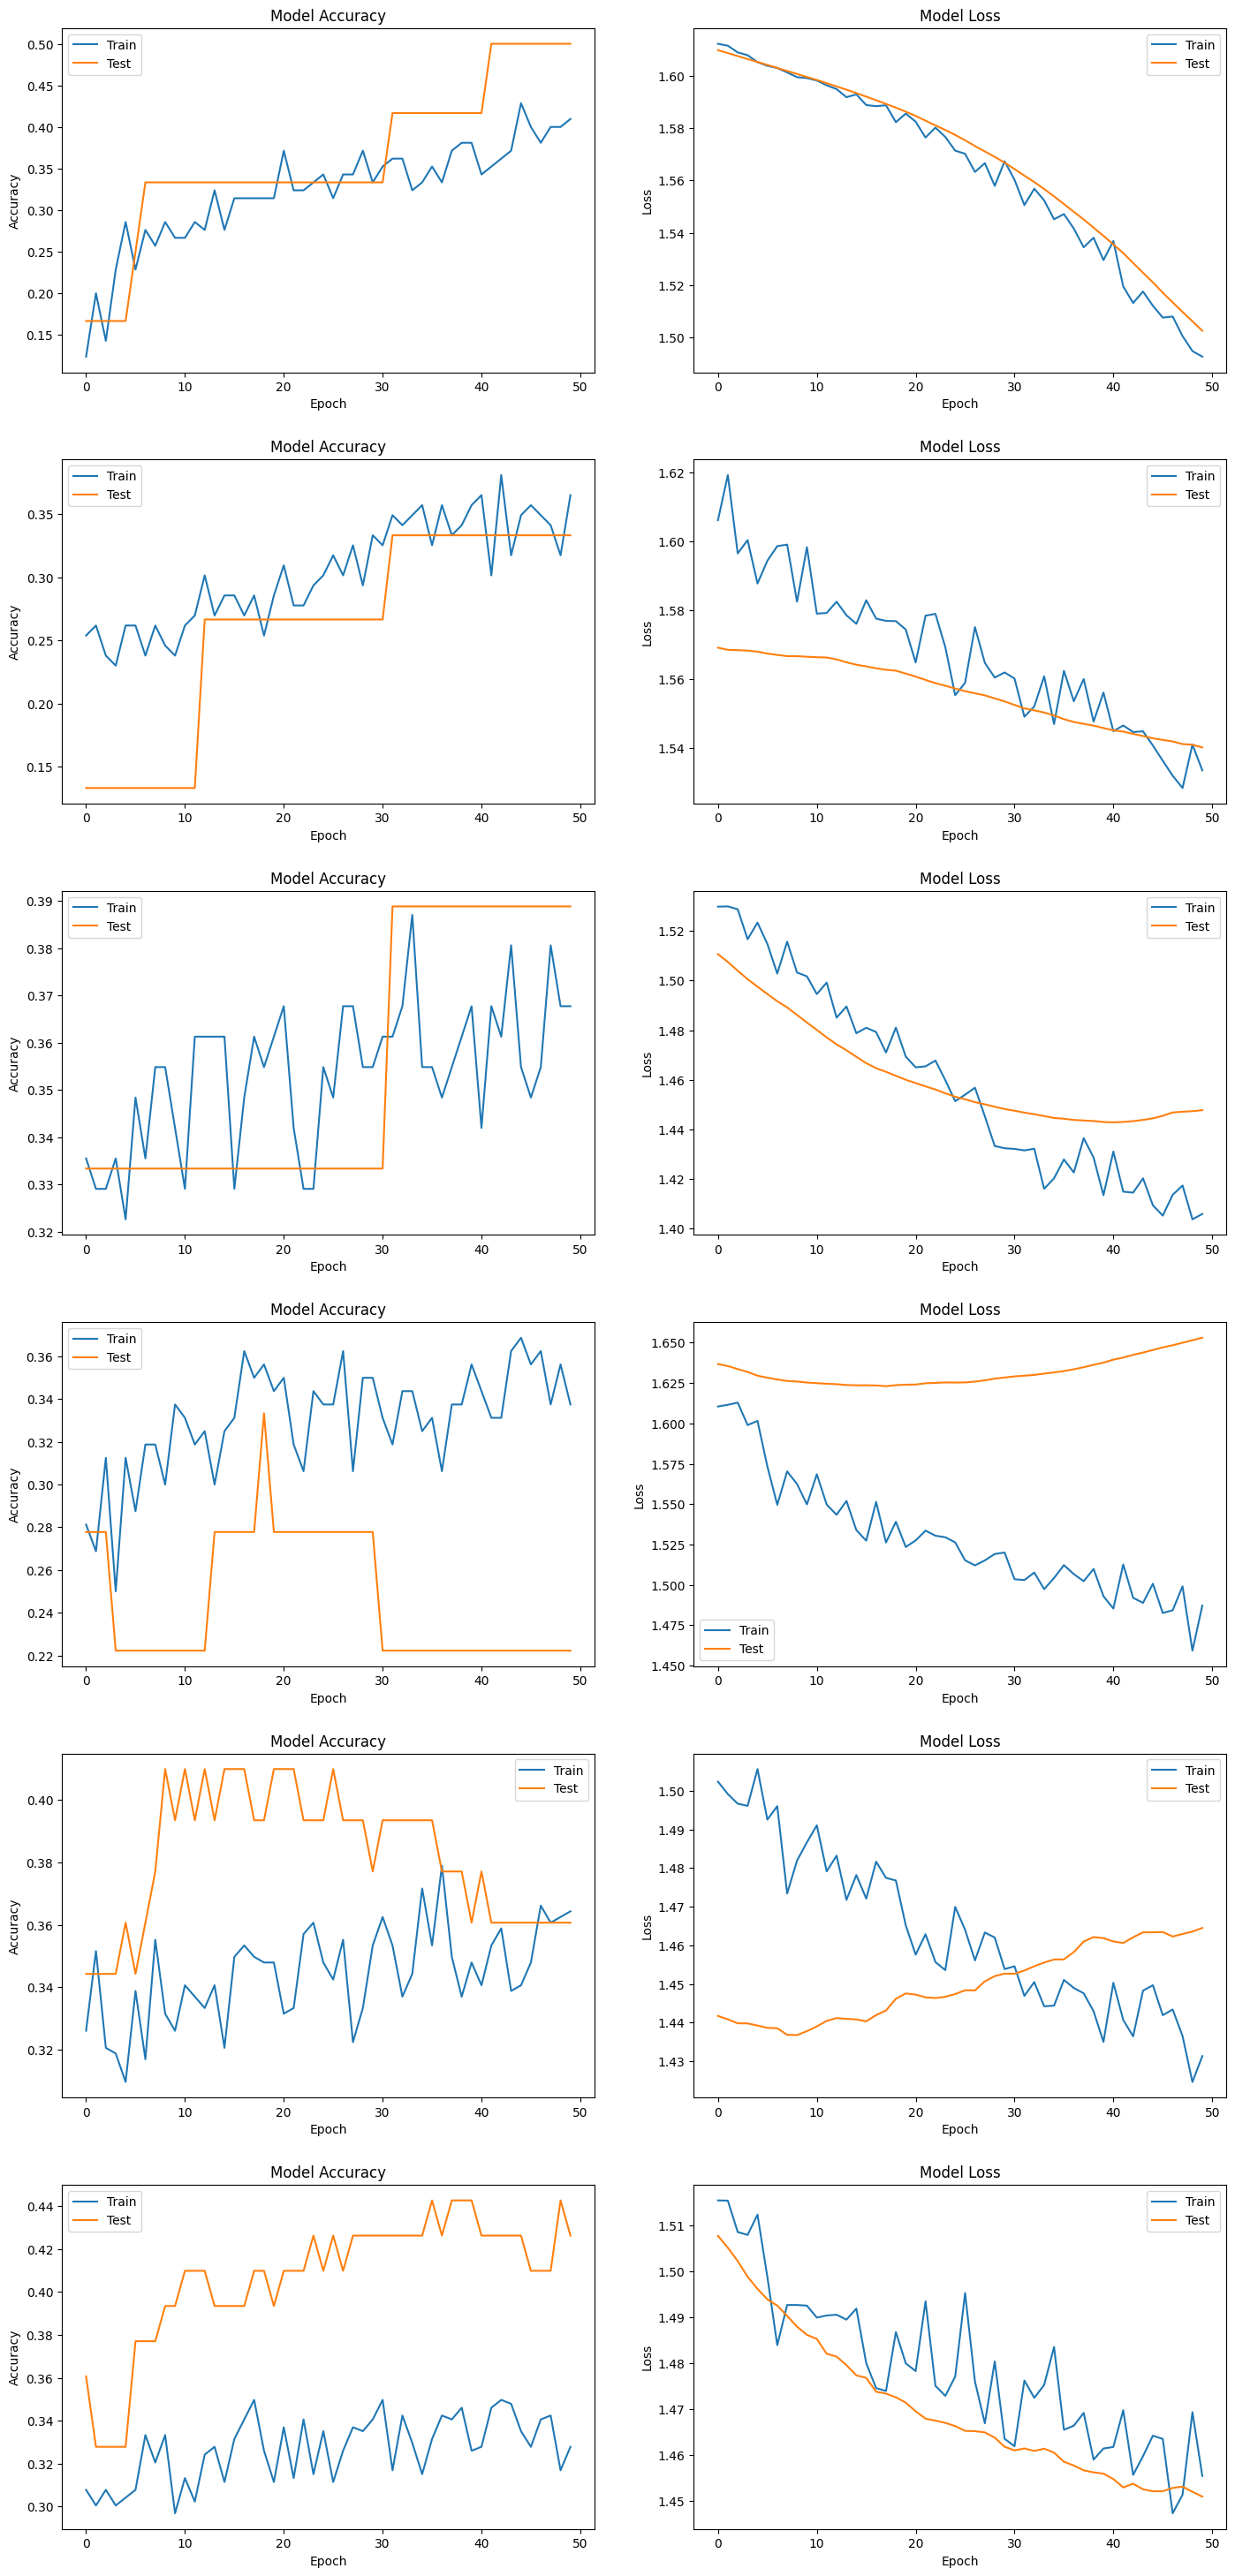

In [21]:
def print_chart(ax, titulo_grafica, x_eje, y_eje, datos_lineas, titulos_lineas):
    """
    Visualización de la pérdida en un subgráfico específico
    ax - ejes del subgráfico
    titulo_grafica - título de la gráfica
    x_eje - título del eje X
    y_eje - título del eje Y
    datos_lineas - lista de series de valores
    titulos_lineas - título de cada linea
    """
    for linea in datos_lineas:
        ax.plot(linea)
    ax.set_title(titulo_grafica)
    ax.set_xlabel(x_eje)
    ax.set_ylabel(y_eje)
    ax.legend(titulos_lineas, loc='best')

# Crear una figura con 12 subgráficos (6 filas y 2 columnas)
fig, axes = plt.subplots(6, 2, figsize=(15, 30))

# Asegurarse de que haya suficiente espacio entre los subgráficos
plt.tight_layout(pad=5.0)

# Alternar entre 'loss' y 'accuracy' para cada par de subgráficos
for idx, history in enumerate(total_simple_lstm_trained[:6]):
    i, j = divmod(idx * 2, 2)
    # Imprimir la gráfica de pérdida en el primer subgráfico del par
    print_chart(axes[i, j], "Model Accuracy", "Epoch", "Accuracy", 
            [history.history['accuracy'], history.history['val_accuracy']], ['Train', 'Test'])
    
    # Imprimir la gráfica de precisión (accuracy) en el segundo subgráfico del par
    i, j = divmod(idx * 2 + 1, 2)
    print_chart(axes[i, j], "Model Loss", "Epoch", "Loss", 
                [history.history['loss'], history.history['val_loss']], ['Train', 'Test'])

# Mostrar todas las gráficas en una sola figura
plt.show()